In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# "" = CPU
# "0" = GPU_0
# "1" = GPU_1
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
# print( 'CUDA Version =', os.environ['CUDA_VERSION'] )

import sys
print( 'Python Version =', sys.version.split()[0] )

import tensorflow as tf
print( 'Tensorflow Version =',tf.__version__)

print("GPU Available: ", tf.test.is_gpu_available())

Python Version = 3.5.2
Tensorflow Version = 1.15.0
GPU Available:  True


In [219]:
import os

from os.path import join
from utils_1 import *
import shutil
import gc
from inspect import getsource
import time

from PIL import Image

from tqdm import tqdm as tqdm
from sklearn.metrics import confusion_matrix

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure, savefig

ImportError: cannot import name 'savefig'

In [131]:
def get_log(file):
    def write(msg):
        with open( file, 'a' ) as f:
            f.write( '%s\n' % msg )
    
    with open(file, 'w'):
        pass
    
    return write

In [132]:
def iou(y_true, y_pred):
    from tensorflow.keras import backend as K
    
    y_pred    = K.argmax( y_pred, axis=-1 )
    y_pred    = K.one_hot(K.cast(y_pred, 'int32'), num_classes=6)
    y_true_f  = K.flatten( y_true[...,1:] )
    y_pred_f  = K.flatten( y_pred[...,1:] )
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    union     = K.sum(y_true_f + y_pred_f, axis=-1) - intersect
    if union == 0:
        return 1.
    return intersect / union


def dice(y_true, y_pred ):
    from tensorflow.keras import backend as K
    y_pred    = K.argmax( y_pred, axis=-1 )
    y_pred    = K.one_hot(K.cast(y_pred, 'int32'), num_classes=6)
    y_true_f  = K.flatten( y_true[...,1:] )
    y_pred_f  = K.flatten( y_pred[...,1:] )
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom     = K.sum(y_true_f + y_pred_f, axis=-1)
    if denom == 0:
        return 1.
    return 2. * intersect / denom


def cate(y_true, y_pred ):
    from tensorflow.keras.metrics import categorical_accuracy
    return categorical_accuracy(y_true, y_pred)


def loss(y_true, y_pred):
    from tensorflow.keras import backend as K
    
    def dice(y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=axis)
        denom        = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis)
        
        return (2. * intersection + smooth) / (denom + smooth)
    
    def iou(y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=axis)
        union        = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) - intersection
        
        return ( intersection + smooth ) / ( union + smooth )
    
    axis = [1,2,3]
    smooth = 1
    gamma = 1.
    loss = 1 - dice( y_true, y_pred )
    return K.pow( loss, gamma )


def get_model(model_path):
    from tensorflow.keras.models import load_model
    return load_model( model_path ,custom_objects={ 'loss_func':loss, 'loss': loss, 'dice':dice , 'iou': iou, 'cate': cate})

In [133]:
def get_x( path ):
    def get_x_rgb( path ):
        rgb = read_image( path, 'rgb' )
        return rgb / 255

    get_x = get_x_rgb
    x = np.array( get_x(path) ).astype( np.float32 )
    return x

def get_y( path ):
    grayscale = read_image( path, 'gray' ) / 51
    layers = [  (grayscale == i) + [0] for i in range(0, 6) ]
      
    return np.stack( layers, axis=2 ).astype( np.float32 )

In [134]:
def calculate_iou( y_true, y_pred ):
    y_pred = y_pred[...,1:].flatten()
    y_true = y_true[...,1:].flatten()
    
    intersection = np.sum( y_pred * y_true )
    union = np.sum( y_pred ) + np.sum( y_true ) - intersection
    
    if union == 0.:
        return 100.
    
    iou_score = intersection / union
    return iou_score * 100


def calculate_dice( y_true, y_pred ):
    y_pred = y_pred[...,1:].flatten()
    y_true = y_true[...,1:].flatten()
    
    intersection = np.sum( y_pred * y_true )
    denom        = np.sum( y_pred ) + np.sum( y_true )
    
    if denom == 0.:
        return 100.
    
    dice_score = 2. * intersection / denom
    return dice_score * 100
    
    
def calculate_region_size_error( y_true, y_pred ):
    y_pred = y_pred[...,1:].flatten()
    y_true = y_true[...,1:].flatten()
    
    gt = np.sum(y_true)
    cs = np.sum(y_pred)
    
    if gt == 0.:
        return 100.
    
    region_size_error = abs( gt - cs ) / gt
    return region_size_error * 100

In [135]:
def get_train_dir(Experiment_DIR):
    path = os.path.join( Experiment_DIR, 'detail.txt' )
    with open( path , 'r' ) as file:
        data = file.read()
    
    desc_index = data.find('Description:')
    desc = data[ desc_index: data.find( '\n', desc_index )  ].split(" ")[-1]
    return desc


def get_history( dirs, Experiment_DIR ):
    losses = []
    val_losses = []
    iou_s = []
    val_iou_s = []
    for fold in dirs:
        fold_DIR = os.path.join( Experiment_DIR, fold )
        history_path = os.path.join( fold_DIR, 'history.npy' )
        
        if not is_exists(history_path):
            raise FileNotFoundError(history_path)
        
        history = np.load( history_path, allow_pickle=True )
        logs = history.item()
        
        losses.append( logs['loss'] )
        val_losses.append( logs['val_loss'] )
        
        iou_s.append( logs['iou'] )
        val_iou_s.append( logs['val_iou'] )
    
    losses     = np.array( losses ).T
    val_losses = np.array(val_losses).T
    iou_s      = np.array( iou_s ).T
    val_iou_s  = np.array( val_iou_s ).T
    
    return ( losses, iou_s ) , ( val_losses, val_iou_s )


# def evaluate_experiment(e, log, model='best', fold=['1']):
   
#     this_ex_dir = join(Experiments_DIR, e)
#     m = model
    
# #     ( losses, iou_s ) , ( val_losses, val_iou_s ) = get_history('1', this_ex_dir)
#     train_dir = get_train_dir(this_ex_dir)
#     model_selected = '%s_model.h5' % m
    
#     print( "*" * 50 )
#     print( '%15s' % 'Data:', train_dir )
#     print( '%15s' % 'Experiments:', e )
#     print( '%15s' % 'Model_selected:', model_selected )
#     print( '%15s' % 'Fold:', fold )
    
#     start_evaluate(fold, this_ex_dir, model_selected, log, m)
    

# def evaluate_sub( model, this_ex_dir, log, m ):
#     tic = time.time()
#     iou_list = []
#     dice_list = []
#     rse_list = []
#     con_ = np.zeros(shape=(6,6))
#     log('Evaluate Sub-Image:')
#     log( '\t'.join( [ '%20s' % 'file_path'] + list(map( lambda x: '%5s' % x, ['iou', 'dice', 'rse', 'time' ] ))) )
#     sengmented_images = []
#     for i in tqdm( range(num_sub_original_images), desc='Sub-Image:' ):
#         original_img_path = sub_original_image_paths[i]
#         label_img_path = sub_label_image_paths[i]
#         iou_, dice_, rse_, segmented, con, time_ = evaluate_sample_sub(model, original_img_path, label_img_path)
    
#         line = '\t'.join(
#             [ "%20s" % original_img_path.split(os.sep)[-1]] + list( map(lambda x: '%-3.2f' % x, [iou_, dice_, rse_, time_]) ) 
#             )
#         log( line )
#         print(line)
#         iou_list.append(iou_)
#         dice_list.append(dice_)
#         rse_list.append(rse_)
#         sengmented_images.append(segmented)
#         con_ += con
    
#     results = [ (i, iou_list[i], dice_list[i], rse_list[i])
#                for i in range(len(iou_list)) ]
    
#     sorted_results = sorted( results,
#                            key=lambda item: (item[1], item[2], item[3]) , reverse=True)
    
    
#     sub_dir = os.path.join(this_ex_dir, m, 'sub')
#     if os.path.exists(sub_dir):
#         shutil.rmtree(sub_dir)
#     os.mkdir(sub_dir)
#     for x, (i, iou_, dice_, rse_) in enumerate(sorted_results):
#         title = "iou=%.2f, dice=%.2f, rse=%.2f" % (iou_, dice_, rse_)
#         l_img = read_image( sub_label_image_paths[i], 'gray' )
#         ori_img = read_image( sub_original_image_paths[i], 'rgb' )
#         f = plot_sample(title=title, label=l_img, original=ori_img, predict=sengmented_images[i])
#         f.savefig( join(sub_dir, 'rank_by_iou_%s.png' % str(x+1).zfill(4) ) )
#         plt.close(f)
    
    
#     reversed_results = reversed(sorted_results)
    
#     best_case = sorted_results[:3]
#     worst_case = list(reversed_results)[:3]
    
#     print('Best Cases:')
#     for x, (i, iou_, dice_, rse_) in enumerate(best_case):
#         title = "iou=%.2f, dice=%.2f, rse=%.2f" % (iou_, dice_, rse_)
#         l_img = read_image( sub_label_image_paths[i], 'gray' )
#         ori_img = read_image( sub_original_image_paths[i], 'rgb' )
#         f = plot_sample(title=title, label=l_img, original=ori_img, predict=sengmented_images[i])
#         f.savefig( join(this_ex_dir, m, 'model_%s_Best-Sub-No-%d.png' % (m, x+1) ) )
#         plt.close(f)
        
#     print('Worst Cases:')
#     for x, (i, iou_, dice_, rse_) in enumerate(worst_case):
#         title = "iou=%.2f, dice=%.2f, rse=%.2f" % (iou_, dice_, rse_)
#         l_img = read_image( sub_label_image_paths[i], 'gray' )
#         ori_img = read_image( sub_original_image_paths[i], 'rgb' )
#         f = plot_sample(title=title, label=l_img, original=ori_img, predict=sengmented_images[i])
#         f.savefig( join(this_ex_dir, m, 'model_%s_Worst-Sub-No-%d.png' % (m, x+1) ) )
#         plt.close(f)
        
    
#     mean_iou = np.mean( iou_list )
#     mean_dice = np.mean( dice_list )
#     mean_rse = np.mean( rse_list )
    
#     return mean_iou, mean_dice, mean_rse, con_
    

# def evaluate_original( model, this_ex_dir, log , m):
#     tic = time.time()
#     iou_list = []
#     dice_list = []
#     rse_list = []
#     con_ = np.zeros(shape=(4,4))
    
#     sengmented_images = []
#     log('Evaluate Original:')
#     log( '\t'.join( [ '%20s' % 'file_path'] + list(map( lambda x: '%5s' % x, ['iou', 'dice', 'rse', 'time' ] ))) )
#     for i in tqdm( range(num_original_images), desc='Original Image:' ):
#         original_img_path = original_image_paths[i]
#         label_img_path = label_image_paths[i]
#         iou_, dice_, rse_, segmented, con, time_ = evaluate_sample(model, original_img_path, label_img_path)
    
#         line = '\t'.join(
#             [ "%20s" % original_img_path.split(os.sep)[-1]] + list( map(lambda x: '%-3.2f' % x, [iou_, dice_, rse_, time_]) ) 
#             )
#         log( line )
#         print(line)
        
#         iou_list.append(iou_)
#         dice_list.append(dice_)
#         rse_list.append(rse_)
#         con_ += con
#         sengmented_images.append(segmented)
    
#     results = [ (i, iou_list[i], dice_list[i], rse_list[i])
#                for i in range(len(iou_list)) ]
    
#     sorted_results = sorted( results,
#                            key=lambda item: (item[1], item[2], item[3]) , reverse=True)
    
#     sub_dir = os.path.join(this_ex_dir, m, 'ori')
#     if os.path.exists(sub_dir):
#         shutil.rmtree(sub_dir)
#     os.mkdir(sub_dir)
#     for x, (i, iou_, dice_, rse_) in enumerate(sorted_results):
#         title = "iou=%.2f, dice=%.2f, rse=%.2f" % (iou_, dice_, rse_)
#         l_img = read_image( label_image_paths[i], 'gray' )
#         ori_img = read_image( original_image_paths[i], 'rgb' )
#         f = plot_sample(title=title, label=l_img, original=ori_img, predict=sengmented_images[i])
#         f.savefig( join(sub_dir, 'rank_by_iou_%s.png' % str(x+1).zfill(4) ) )
#         plt.close(f)
        
# #     reversed_results = reversed(sorted_results)
    
# #     best_case = sorted_results[:3]
# #     worst_case = list(reversed_results)[:3]
    
# #     print('Best Cases:')
# #     for x, (i, iou_, dice_, rse_) in enumerate(best_case):
# #         title = "iou=%.2f, dice=%.2f, rse=%.2f" % (iou_, dice_, rse_)
# #         l_img = read_image( label_image_paths[i], 'gray' )
# #         ori_img = read_image( original_image_paths[i], 'rgb' )
# #         f = plot_sample(title=title, label=l_img, original=ori_img, predict=sengmented_images[i])
# #         f.savefig( join(this_ex_dir, m, 'model_%s_Best-Ori-No-%d.png' % (m, x+1) ) )
# #         plt.close(f)
        
# #     print('Worst Cases:')
# #     for x, (i, iou_, dice_, rse_) in enumerate(worst_case):
# #         title = "iou=%.2f, dice=%.2f, rse=%.2f" % (iou_, dice_, rse_)
# #         l_img = read_image( label_image_paths[i], 'gray' )
# #         ori_img = read_image( original_image_paths[i], 'rgb' )
# #         f = plot_sample(title=title, label=l_img, original=ori_img, predict=sengmented_images[i])
# #         f.savefig( join(this_ex_dir, m, 'model_%s_Worst-Ori-No-%d.png' % (m,x+1) ) )
# #         plt.close(f)
        
    
#     mean_iou = np.mean( iou_list )
#     mean_dice = np.mean( dice_list )
#     mean_rse = np.mean( rse_list )
    
#     return mean_iou, mean_dice, mean_rse, con_


def window_generator( windows, b_size ):
    def load( windows ):
        x = np.asarray( windows ).astype(np.float32)
        return x
    
    L = len(windows)
    
    while True:
        batch_start = 0
        batch_end = b_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            x     = load( windows[batch_start:limit] )
            yield x
            batch_start += b_size
            batch_end   += b_size


    

# def evaluate_sample( model, f_path, l_path ):
#     f_img = get_x(f_path)
#     l_img = get_y(l_path)
    
#     f_areas = sub_images(f_img, window_shape, stride)
    
#     f_windows = [ win for _, win in f_areas ]
    
#     coor_f = [ coor for coor, _ in f_areas ]
    
#     win_gen = window_generator( f_windows, b_size )
    
#     y_pred = model.predict_generator(
#         generator=win_gen,
#         steps=len(f_windows) / b_size
#     )
    
#     pred_area = [ ( coor_f[i], y_pred[i] ) for i in range(len(coor_f)) ]
#     shape_ = f_img.shape[:2] + ( y_pred.shape[-1], )

#     tic = time.time()
    
#     y_ori_pred = reconstruct_image( pred_area, shape_ )
    
#     toc = time.time()
# #     print('Process Time of %s: %.2f second' % ( f_path.split(os.sep)[-1] ,toc-tic))
    
#     y_pred = np.eye( 6 )[y_ori_pred.argmax(axis=-1)]
#     y_true = l_img
    
#     iou_ = calculate_iou( y_true, y_pred )
#     dice_ = calculate_dice( y_true, y_pred )
#     rse_ = calculate_region_size_error( y_true, y_pred)
    
#     con = confusion_matrix( y_true.argmax(axis=-1 ).flatten(), y_pred.argmax(axis=-1 ).flatten(), labels=[0,1,2,3,4,5] )
    
#     print(np.unique(y_pred))
#     segmented = y_ori_pred.argmax(axis=-1 ) * 51
#     print(np.unique(segmented))
#     return iou_, dice_, rse_, segmented, con, toc - tic


# def start_evaluate(fold, this_ex_dir, model_selected, log, m):
    
#     dice_list = []
#     iou_list = []
#     rse_list = []
    
#     sub_dice_list = []
#     sub_iou_list = []
#     sub_rse_list = []
    
#     con_ori = np.zeros(shape=(6,6))
#     con_sub = np.zeros(shape=(6,6))
    
#     for f in tqdm( fold, desc="EVALUATE:" ):
        
#         tmp_p = os.path.join( this_ex_dir, f, m )
#         if os.path.exists(tmp_p):
#             shutil.rmtree(tmp_p)
#         os.mkdir( tmp_p )
        
#         gc.collect()
#         fold_dir = join( this_ex_dir, f )
#         log('start_evaluate: %s' % f )
        
#         if not is_exists(fold_dir):
#             raise FileNotFoundError(fold_dir)
            
#         model_path = join( fold_dir, model_selected )
#         if not is_exists(model_path):
#             raise FileNotFoundError(model_path)
        
#         print( 'Loading %s...' % model_path, end='\r' )
#         tic = time.time()
#         model = get_model( model_path )
#         toc = time.time()
#         print( 'Finished loading %s in %.2f seconds.' % ( model_path ,toc - tic ))
        
# #         iou_, dice_, rse_, con_ = evaluate_original( model, fold_dir, log, m )
#         iou_, dice_, rse_, con_ = 0, 0, 0, np.zeros(shape=(6,6))
#         iou_sub, dice_sub, rse_sub, con__ = evaluate_sub( model, fold_dir, log, m )
        
#         con_ori += con_
#         con_sub += con__
        
#         log_path = join( fold_dir, m, '%s_Results.txt' % m )
#         log__ = get_log(log_path)
#         log__('Original Result:')
#         log__('IoU = %.2f' % iou_)
#         log__('Dice = %.2f' % dice_)
#         log__('rse = %.2f' % rse_)
        
        
#         log__('\nSub-Images Result:')
#         log__('IoU = %.2f' % iou_sub)
#         log__('Dice = %.2f' % dice_sub)
#         log__('rse = %.2f' % rse_sub)
        
#         print( con_ )
#         log__('\nConfusion Matrix Original:')
#         line_1 = "%15s %15s %15s %15s %15s" % ('actual\\predict', 'background', 'granulation', 'slough', 'necrosis')
#         line_2 = "%15s %15d %15d %15d %15d" % ('background', con_[0,0], con_[0,1], con_[0,2], con_[0,3]) 
#         line_3 = "%15s %15d %15d %15d %15d" % ('granulation', con_[1,0], con_[1,1], con_[1,2], con_[1,3]) 
#         line_4 = "%15s %15d %15d %15d %15d" % ('slough', con_[2,0], con_[2,1], con_[2,2], con_[2,3]) 
#         line_5 = "%15s %15d %15d %15d %15d" % ('necrosis', con_[3,0], con_[3,1], con_[3,2], con_[3,3])
#         msg = '\n'.join( [line_1,line_2,line_3,line_4,line_5] )
#         log__(msg)

#         print( con__ )
#         log__('\n\nConfusion Matrix Sub-Images:')
#         line_1 = "%15s %15s %15s %15s %15s" % ('actual\\predict', 'background', 'granulation', 'slough', 'necrosis')
#         line_2 = "%15s %15d %15d %15d %15d" % ('background', con__[0,0], con__[0,1], con__[0,2], con__[0,3]) 
#         line_3 = "%15s %15d %15d %15d %15d" % ('granulation', con__[1,0], con__[1,1], con__[1,2], con__[1,3]) 
#         line_4 = "%15s %15d %15d %15d %15d" % ('slough', con__[2,0], con__[2,1], con__[2,2], con__[2,3]) 
#         line_5 = "%15s %15d %15d %15d %15d" % ('necrosis', con__[3,0], con__[3,1], con__[3,2], con__[3,3])
#         msg = '\n'.join( [line_1,line_2,line_3,line_4,line_5] )
#         log__(msg)
        
#         iou_list.append( iou_ )
#         dice_list.append( dice_ )
#         rse_list.append( rse_ )
        
#         sub_iou_list.append( iou_sub )
#         sub_dice_list.append( dice_sub )
#         sub_rse_list.append( rse_sub )
        
#         del model
#         gc.collect()
    
#     mean_iou = np.mean( iou_list )
#     mean_dice = np.mean( dice_list )
#     mean_rse = np.mean( rse_list )
    
#     mean_iou_sub = np.mean( sub_iou_list )
#     mean_dice_sub = np.mean( sub_dice_list )
#     mean_rse_sub = np.mean( sub_rse_list )
    
#     log_path = join(this_ex_dir, '%s_Results.txt' % m)
#     log_ = get_log(log_path)
    
#     print('Original Result:')
#     print('Mean IoU = %.2f' % mean_iou)
#     print('Mean Dice = %.2f' % mean_dice)
#     print('Mean rse = %.2f' % mean_rse)
    
#     print('\nSub-Images Result:')
#     print('Mean IoU = %.2f' % mean_iou_sub)
#     print('Mean Dice = %.2f' % mean_dice_sub)
#     print('Mean rse = %.2f' % mean_rse_sub)
    
#     log_('Originl Result:')
#     log_('Mean IoU = %.2f' % mean_iou)
#     log_('Mean Dice = %.2f' % mean_dice)
#     log_('Mean rse = %.2f' % mean_rse)
    
#     log_('\nSub-Images Result:')
#     log_('Mean IoU = %.2f' % mean_iou_sub)
#     log_('Mean Dice = %.2f' % mean_dice_sub)
#     log_('Mean rse = %.2f' % mean_rse_sub)
    
#     print( con_ori )
#     log_('\nConfusion Matrix Original:')
#     line_1 = "%15s %15s %15s %15s %15s" % ('actual\\predict', 'background', 'granulation', 'slough', 'necrosis')
#     line_2 = "%15s %15d %15d %15d %15d" % ('background', con_ori[0,0], con_ori[0,1], con_ori[0,2], con_ori[0,3]) 
#     line_3 = "%15s %15d %15d %15d %15d" % ('granulation', con_ori[1,0], con_ori[1,1], con_ori[1,2], con_ori[1,3]) 
#     line_4 = "%15s %15d %15d %15d %15d" % ('slough', con_ori[2,0], con_ori[2,1], con_ori[2,2], con_ori[2,3]) 
#     line_5 = "%15s %15d %15d %15d %15d" % ('necrosis', con_ori[3,0], con_ori[3,1], con_ori[3,2], con_ori[3,3])
#     msg = '\n'.join( [line_1,line_2,line_3,line_4,line_5] )
#     log_(msg)
    
#     print( con_sub )
#     log_('\n\nConfusion Matrix Sub-Images:')
#     line_1 = "%15s %15s %15s %15s %15s" % ('actual\\predict', 'background', 'granulation', 'slough', 'necrosis')
#     line_2 = "%15s %15d %15d %15d %15d" % ('background', con_sub[0,0], con_sub[0,1], con_sub[0,2], con_sub[0,3]) 
#     line_3 = "%15s %15d %15d %15d %15d" % ('granulation', con_sub[1,0], con_sub[1,1], con_sub[1,2], con_sub[1,3]) 
#     line_4 = "%15s %15d %15d %15d %15d" % ('slough', con_sub[2,0], con_sub[2,1], con_sub[2,2], con_sub[2,3]) 
#     line_5 = "%15s %15d %15d %15d %15d" % ('necrosis', con_sub[3,0], con_sub[3,1], con_sub[3,2], con_sub[3,3])
#     msg = '\n'.join( [line_1,line_2,line_3,line_4,line_5] )
#     log_(msg)

In [136]:
# # Config
# window_height = 512
# window_width = 512
# window_shape = (window_height, window_width)
# # stride = 128
# b_size = 1


# # dataset_name        = "wound_rajavithi"
# # root                = os.path.join(os.getcwd(), "data", dataset_name, "wound_segmentation")
# # source_dir          = os.path.join(root, "dataset_testing")

# # Test_original_DIR = source_dir  


# # if not is_exists(Test_original_DIR):
# #     raise FileNotFoundError('%s' % Test_original_DIR)

# # f_original_DIR = join( Test_original_DIR, 'feature' )
# # l_original_DIR = join( Test_original_DIR, 'label' )

# # paths = get_list_dir(f_original_DIR)
# # # shuffle(paths)
# # original_image_paths = [ join( f_original_DIR, p) for p in paths]
# # label_image_paths = [ join( l_original_DIR, p) for p in paths]
# # num_original_images = len(original_image_paths)
# # # num_original_images = 2

# dataset_name        = "wound_rajavithi"
# root                = os.path.join(os.getcwd(), "data", dataset_name, "wound_segmentation")
# source_dir          = os.path.join(root, "testing")

# Test_Sub_DIR = source_dir  
# sub_f_original_DIR = join( Test_Sub_DIR, 'feature' )
# sub_l_original_DIR = join( Test_Sub_DIR, 'label' )

# sub_paths = get_list_dir(sub_f_original_DIR)
# # shuffle(sub_paths)
# sub_original_image_paths = [ join( sub_f_original_DIR, p) for p in sub_paths ]
# sub_label_image_paths    = [ join( sub_l_original_DIR, p) for p in sub_paths ]
# num_sub_original_images  = len(sub_original_image_paths)
# # num_sub_original_images = 2

# experiment_dir      = "experiments"
# root                = join(os.getcwd(), "data", dataset_name, "wound_segmentation")



# Experiments_DIR = join(root ,"experiments")
# experiments = [
#     '0018',
# ]

# # for experiment in experiments:
# #     log_path = os.path.join( Experiments_DIR, 'eval_log.txt' )
# #     log_file = get_log( log_path )
# #     log_file( 'Original Test Image: %d images' % num_original_images )
# #     log_file( 'Sub-images Test Image: %d images' % num_sub_original_images )
# #     evaluate_experiment( experiment, log_file, model='end', fold=['8'] )
# #     evaluate_experiment( experiment, log_file, model='200', fold=['1'] )
# #     evaluate_experiment( experiment, log_file, model='best', fold=['1'] )
    
# # exit()

In [706]:
# Config
window_height = 512
window_width = 512
window_shape = (window_height, window_width)
model_path = "data/best_model.h5"
# stride = 128
b_size = 1

dataset_name        = "wound_rajavithi"
root                = os.path.join(os.getcwd(), "data", dataset_name, "wound_segmentation")

# data_set_dir            = "training"
data_set_dir            = "testing"

source_dir          = os.path.join(root, data_set_dir)
evaluate_dir        = os.path.join(root, data_set_dir, "predict") 
evaluate_image_dir  = os.path.join(evaluate_dir, "images")
evaluate_fig_dir    = os.path.join(evaluate_dir, "figure")

os.makedirs(evaluate_dir, exist_ok=True)
os.makedirs(evaluate_image_dir, exist_ok=True)
os.makedirs(evaluate_fig_dir, exist_ok=True)

Test_Sub_DIR = source_dir  
sub_f_original_DIR = join( Test_Sub_DIR, 'feature' )
sub_l_original_DIR = join( Test_Sub_DIR, 'label' )

sub_paths = get_list_dir(sub_f_original_DIR)
sub_paths = sorted(sub_paths, key= lambda x: int(x.replace(".png", "")))

sub_original_image_paths = [ join( sub_f_original_DIR, p) for p in sub_paths ]
sub_label_image_paths    = [ join( sub_l_original_DIR, p) for p in sub_paths ]
num_sub_original_images  = len(sub_original_image_paths[:20])
# num_sub_original_images = 2
class_names = ['background', "unstate", 'necrosis', 'slough', 'granulation', "epithelial"]

root                = join(os.getcwd(), "data", dataset_name, "wound_segmentation")


In [700]:
model = get_model(model_path)

In [718]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(confusion_matrix_all, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix_all
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig
# np.set_printoptions(precision=2)

In [733]:
def labelGray2Color(image, color_class):
#     print("unique color: ",np.unique(image))
    label_color = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    label_color[image == 0]    = color_class[0]
    label_color[image == 51*1] = color_class[1]
    label_color[image == 51*2] = color_class[2]
    label_color[image == 51*3] = color_class[3]
    label_color[image == 51*4] = color_class[4]
    label_color[image == 51*5] = color_class[5]
    return label_color

def plot_sample(title, original, label, predict):
    
    color_class = [(0, 0, 0), (128, 128, 128), (128, 0, 64), (230, 0, 0),  (255, 255, 102), (255, 153, 102)]
    tmp_labels = ['background', "unstate", 'necrosis',  'granulation', 'slough', "epithelial"]
    
    f, (a1, a2, a3, a4) = plt.subplots( 1, 4, figsize=(15,8) )
    f.suptitle( title )
    a1.set_title('Original')
    a1.imshow( original )
    
    a2.set_title('Label')
    label = labelGray2Color(label, color_class)
    im2 = a2.imshow(label)
#     a2.figure.colorbar(im2, ax=a2) 
    
    a3.set_title('Predict')
    predict = labelGray2Color(predict, color_class)
    im3 = a3.imshow( predict)
#     a3.figure.colorbar(im3, ax=a3)
    
#     print(color_class)
    a4.set(yticks=np.arange(6),
           yticklabels= tmp_labels,
           title='Class Color')
    a4.get_xaxis().set_ticks([])
    re_color_class = np.reshape(color_class, (6, 1, 3))
#     print(re_color_class)
    a4.imshow(re_color_class, interpolation='nearest')
    
    return f

def confusion2string(title, confusion, class_names, normalize=False):
#     print(confusion.shape)
#     print(confusion)
#     print(zip(*class_names))
    temp_lines = ['{}:'.format(title),
                 "%15s %15s %15s %15s %15s %15s %15s" % ('actual\\predict', *class_names)]
    if normalize == True:
        for i, data in enumerate(confusion):
#             print(np.unique(data))
            data = data / np.sum(data) if np.sum(data) != 0 else data
            temp_lines += ["%15s %15s %15s %15s %15s %15s %15s" % (class_names[i], *["{:,.2f}".format(x) for x in data])]
    else:
        for i, data in enumerate(confusion):
            temp_lines += ["%15s %15s %15s %15s %15s %15s %15s" % (class_names[i], *["{:,}".format(int(x)) for x in data])]

    return '\n'.join(temp_lines) + "\n\n"

In [734]:
def evaluate_sample_sub( model, f_path, l_path ):
    tic = time.time()
    f_img = get_x(f_path)
    l_img = get_y(l_path)
    
    f_windows = [ f_img ]
    win_gen = window_generator( f_windows, b_size )
    
    y_pred = model.predict_generator(
        generator=win_gen,
        steps=len(f_windows) / b_size
    )
    y_ori_pred = y_pred.squeeze()
    
    y_pred = np.eye( 6 )[y_ori_pred.argmax(axis=-1 )]
    y_true = l_img
    
    iou_  = calculate_iou( y_true, y_pred )
    dice_ = calculate_dice( y_true, y_pred )
    rse_  = calculate_region_size_error( y_true, y_pred )
    confusion   = confusion_matrix( y_true.argmax(axis=-1 ).flatten(), y_pred.argmax(axis=-1 ).flatten(), labels=[0,1,2,3,4,5] )
      
    segmented = y_ori_pred.argmax(axis=-1 ) * 51
    toc = time.time()
    return iou_, dice_, rse_, segmented, confusion, toc - tic

def evaluate(model):
    
    temp_sort_iou = []
    tic = time.time()
    iou_list = []
    dice_list = []
    rse_list = []
    confusion_matrix_all= np.zeros(shape=(6,6))
    sengmented_images = []
    log = ""
    line = '\t'.join(
            [ "%s" % "image_name"] + list( map(lambda x: '%5s' % x, ["IoU", "Dice", "RSE", "Time"]) ) 
            ) + "\n"
    log += line
#     print(line)
    for i in tqdm( range(num_sub_original_images), desc='Sub-Image:' ):
        original_img_path = sub_original_image_paths[i]
        label_img_path = sub_label_image_paths[i]
  
        iou_, dice_, rse_, segmented, con, time_ = evaluate_sample_sub(model, original_img_path, label_img_path)
        temp_sort_iou += [ [original_img_path.split(os.sep)[-1],original_img_path, label_img_path, iou_, dice_, rse_, segmented, con, time_]]
        
    for image_name, original_img_path, label_img_path, iou_, dice_, rse_, segmented, confusion, time_ in sorted(temp_sort_iou, key=lambda x: x[3], reverse=True):
        line = '\t'.join(
            [ "%s" % image_name] + list( map(lambda x: '%-3.2f' % x, [iou_, dice_, rse_, time_]) ) 
            ) + "\n"
    #     print(line)
        log += line
        
        fig_image_path          = os.path.join(evaluate_fig_dir , label_img_path.split(os.sep)[-1].replace(".png", "_fig.png"))
        feature_img             = cv2.cvtColor(cv2.imread(original_img_path), cv2.COLOR_BGR2RGB)
        label_image             = cv2.imread(label_img_path, cv2.IMREAD_GRAYSCALE)
        tmp_title = [label_img_path.split(os.sep)[-1]] 
        tmp_title += ["{: >12}:{:.2f}".format(x[0], x[1]) for x in list(zip(["iou", "mean_dice", "mean_rse"], [iou_, dice_, rse_, time_]))]
        title_fig = "".join(tmp_title)
        fig_image               = plot_sample(title_fig, feature_img, label_image, segmented)
#         fig_image.savefig(fig_image_path)
        
#         fig_cufusion_path       = os.path.join(evaluate_image_dir , label_img_path.split(os.sep)[-1].replace(".png", "_confusion.png"))
        fig_confusion           = plot_confusion_matrix(confusion.astype(int), 
                                                        classes=class_names,title='Confusion matrix, without normalization',
                                                        normalize=True,
                                                        figsize = (5,5))
#         fig_confusion.savefig(fig_cufusion_path)
        
        predict_image_path      = os.path.join(evaluate_image_dir , label_img_path.split(os.sep)[-1])
#         cv2.imwrite(predict_image_path, segmented)
        
#         sub_confusion = confusion2string(title="Sub-Confusion Matrix", confusion= confusion, class_names=class_names)
#         log += sub_confusion
        
        iou_list.append(iou_)
        dice_list.append(dice_)
        rse_list.append(rse_)
        sengmented_images.append(segmented)
        
        confusion_matrix_all += con
    
    mean_iou       = np.mean( iou_list )
    mean_dice      = np.mean( dice_list )
    mean_rse       = np.mean( rse_list )
    
    log += "\n" + '\n'.join(["{}\t{:.4f}".format(x[0], x[1]) for x in 
                             list(zip(["mean_iou", "mean_dice", "mean_rse"],[mean_iou, mean_dice, mean_rse]))]) + "\n"
    
    summary_confusion = confusion2string(title="Summary Confusion Matrix", confusion=
                           confusion_matrix_all, class_names=class_names)
    log += summary_confusion
    
    summary_confusion_normalize = confusion2string(title="Summary Confusion Matrix Normalize", confusion=
                           confusion_matrix_all, class_names=class_names, normalize=True)
    log += summary_confusion_normalize
    
    print(log)
    with open(os.path.join(evaluate_dir, "log.txt"), 'w') as f:
        f.write(log)
        
    
    return iou_list, dice_list, rse_list, confusion_matrix_all, sengmented_images

Sub-Image:: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


image_name	  IoU	 Dice	  RSE	 Time
00003.png	65.02	78.81	26.36	0.29
00001.png	45.70	62.73	51.37	0.32
00002.png	41.82	58.97	1.01	0.29
00012.png	36.78	53.78	4.66	0.29
00010.png	30.44	46.67	34.94	0.30
00009.png	27.69	43.37	3.23	0.31
00007.png	23.79	38.44	58.59	0.29
00005.png	17.15	29.27	351.47	0.29
00006.png	13.80	24.26	77.33	0.28
00011.png	13.78	24.21	40.48	0.34
00013.png	8.11	15.01	71.07	0.29
00004.png	4.89	9.32	59.19	0.32
00008.png	0.11	0.21	64.62	0.32

mean_iou	25.3138
mean_dice	37.3127
mean_rse	64.9470
Summary Confusion Matrix:
 actual\predict      background         unstate        necrosis          slough     granulation      epithelial
     background       1,456,091               0               0               0             455               0
        unstate       1,096,602               0           2,132          48,906          92,391         204,763
       necrosis         289,887               0         149,253           6,318           6,357          12,064
         slough 

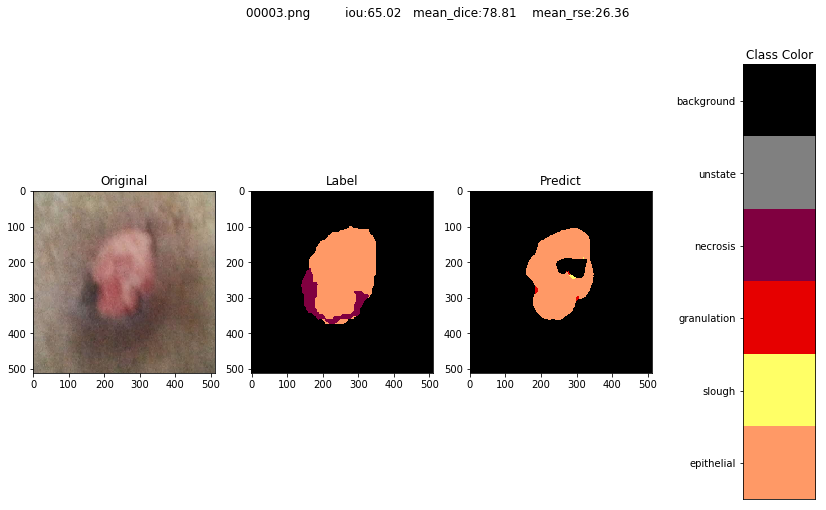

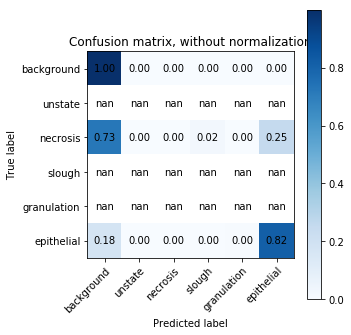

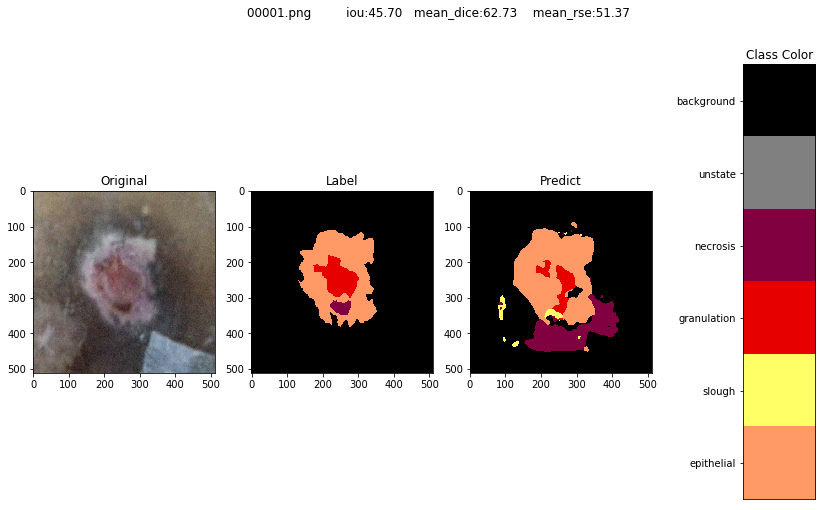

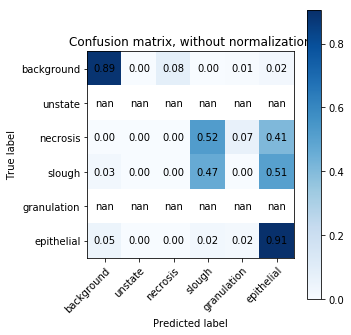

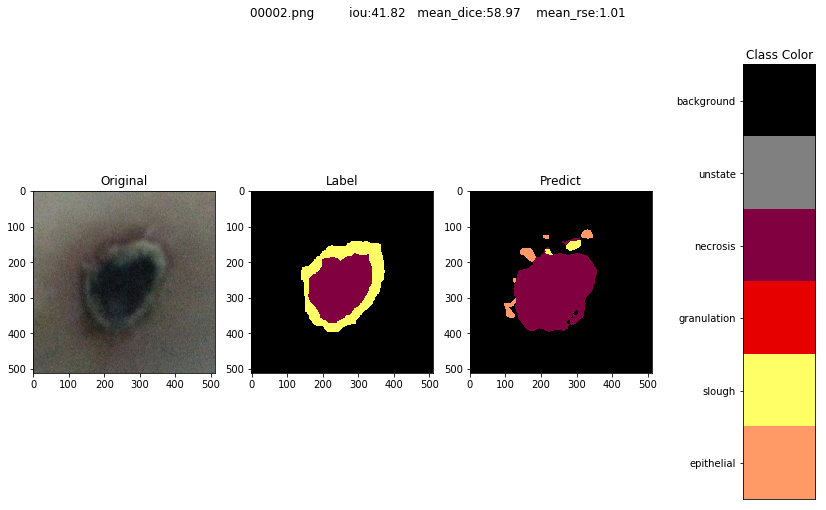

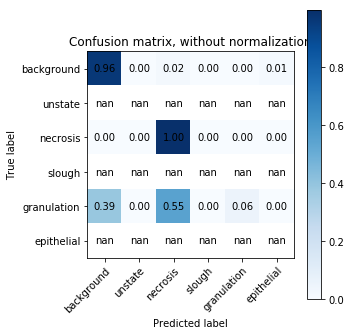

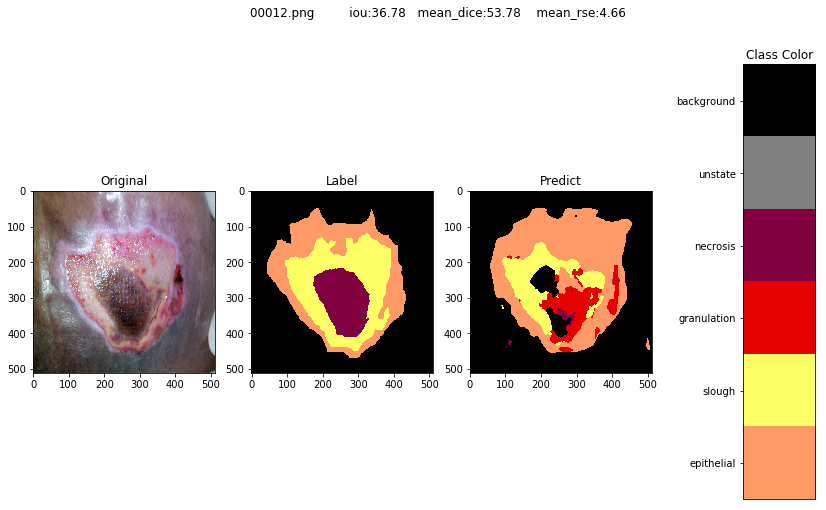

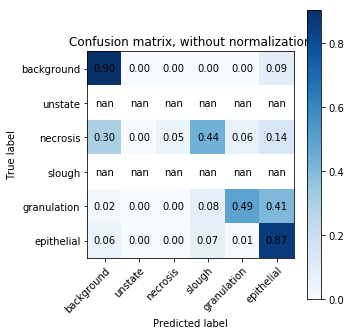

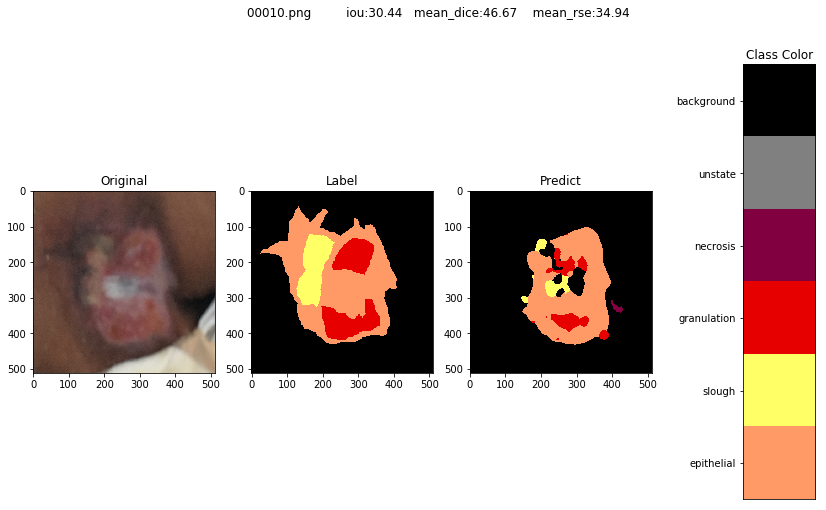

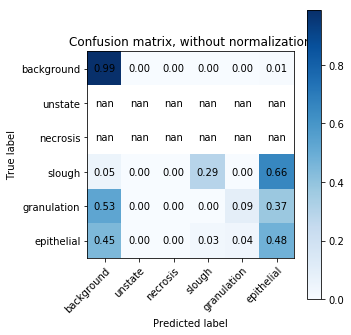

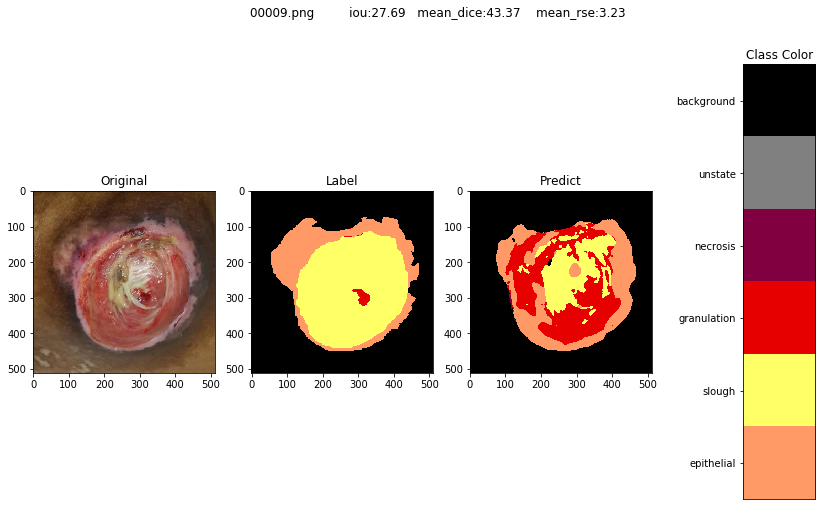

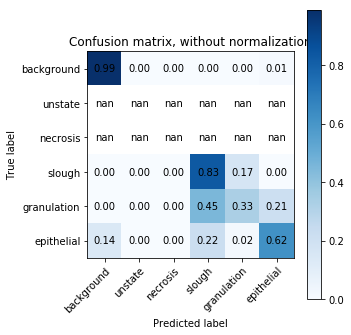

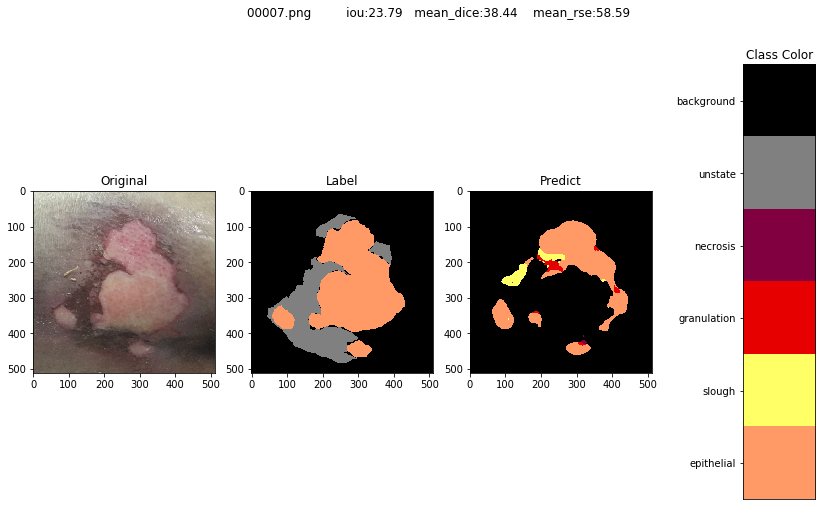

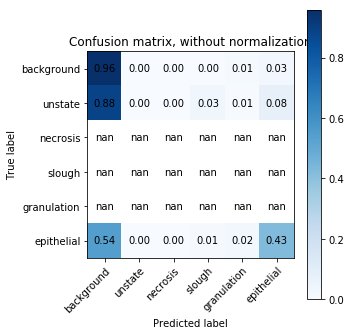

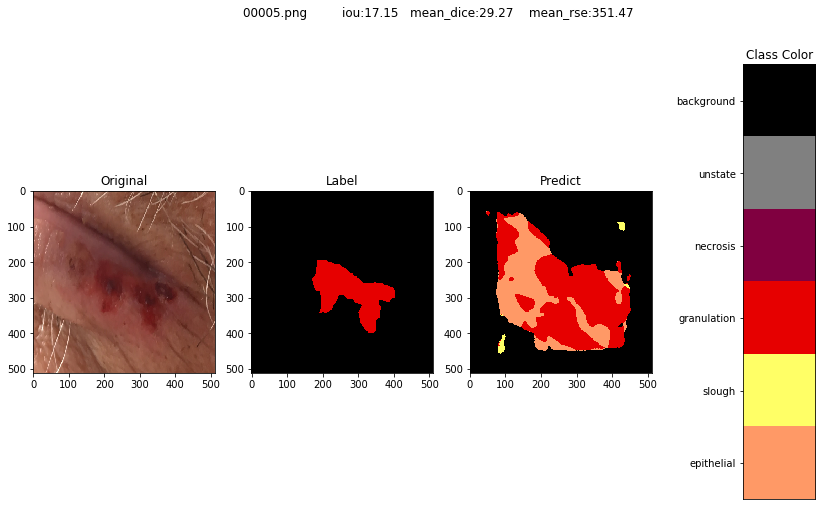

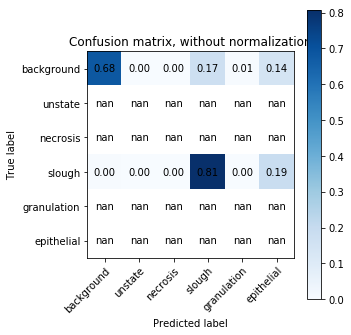

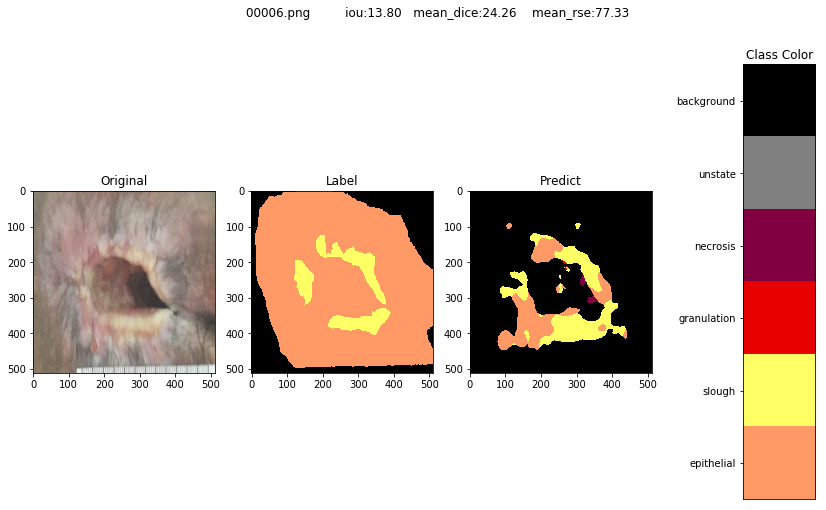

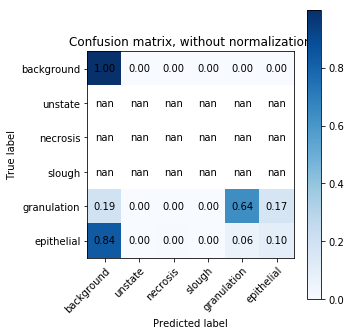

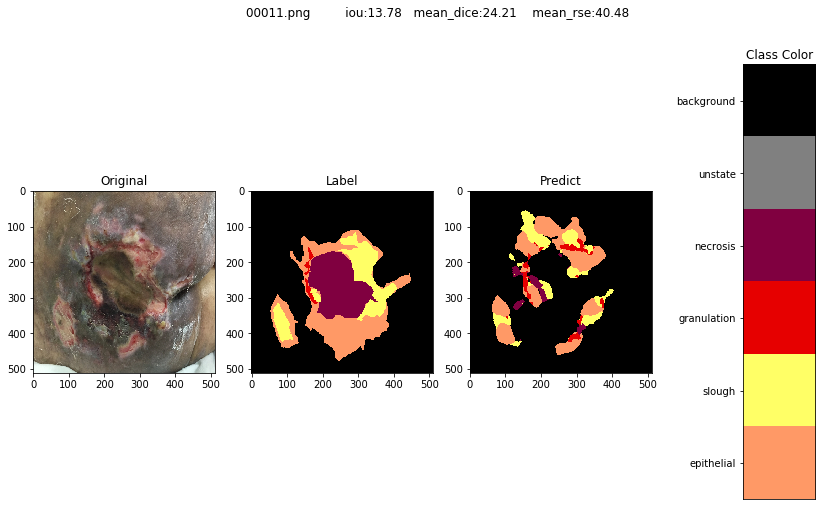

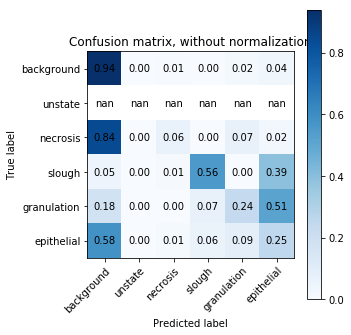

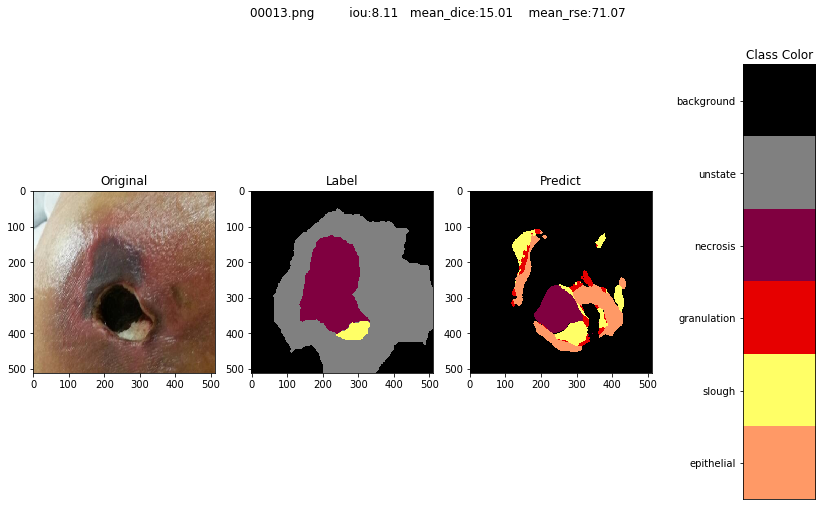

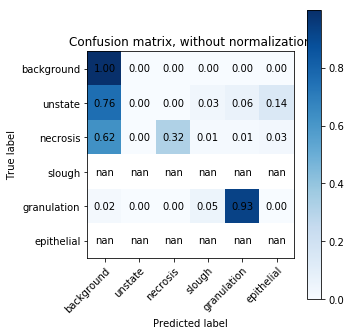

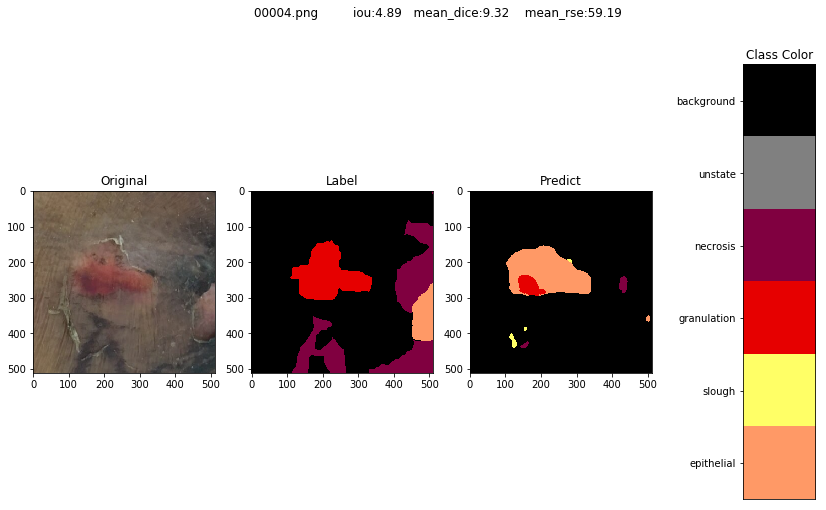

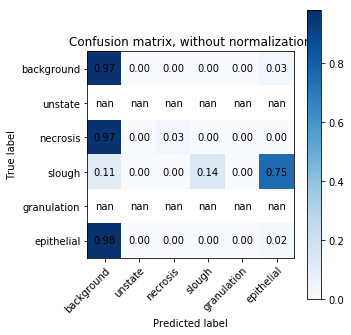

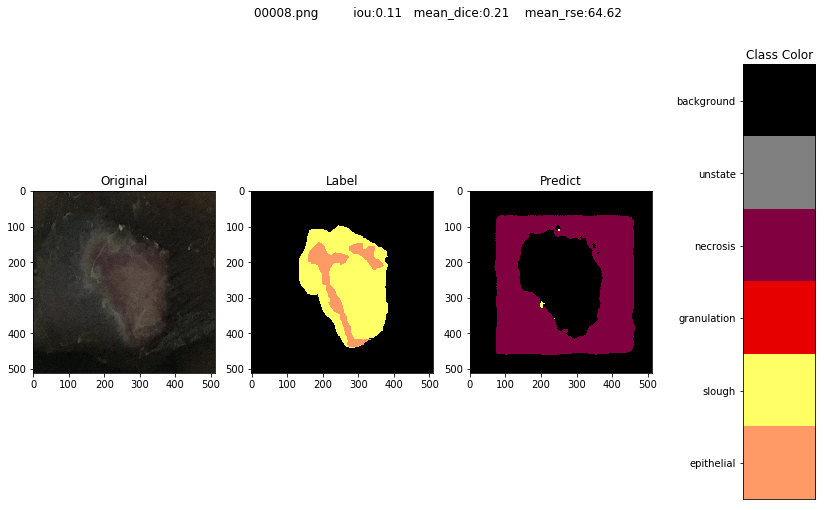

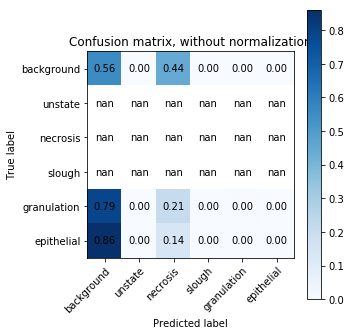

In [735]:
iou_list, dice_list, rse_list, confusion_matrix_all, sengmented_images = evaluate(model) 

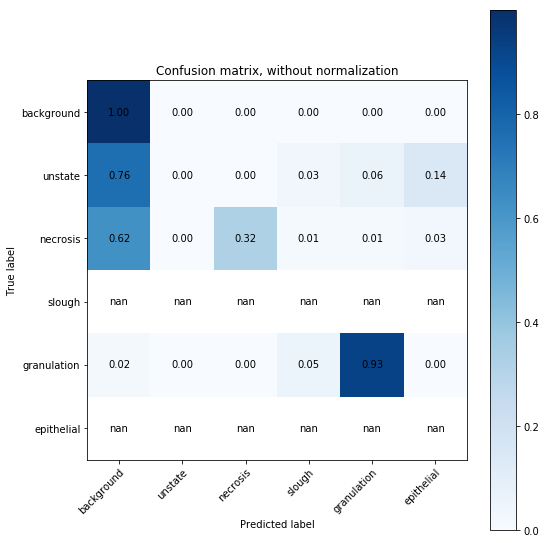

In [736]:
 plot_confusion_matrix(confusion_matrix_all.astype(int), classes=class_names,
                      title='Confusion matrix, without normalization', normalize=True).savefig(os.path.join(evaluate_dir, "confusion-normalize.png"))
   